# Predictive Model

The metrics that will be used to evaluate this stage are:

- **Diversity** of tasks (use of classification and regression) and of algorithms, this is, tested more than 4 with significantly different language bias OR with a significant number of variants.

- **Parameter Tuning**, with a systematic approach.

- **Understanding Algorithm Behavior**, solid (even if not deep) understanding of the behavior of most algorithms used OR <3 algorithms, also understanding the effect of parameters.

- Training and testing on properly separated data, with multiple splits.

- **Performance Estimation**, additional factors correctly taken into account (e.g. time), focus on performance measures aligned with DM goals and data characteristics, advanced performance measures (e.g. AUC), adequate baseline, correct analysis of values ​​for comparison, including tests of statistical significance, correct estimate of overfitting.

- **Model Improvement**, development guided by performance improvement goals, even if pedagogical goals have not been ignored.

- **Feature Importance**, correctly interpreted, related to the application domain.

- Analysis of "white box" models, correctly interpreted, related to the application domain

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report
import time

In [9]:
teams = pd.read_csv("data_prepared/teams.csv")
teams = teams.drop(columns=['teams_firstRound', 'teams_semis', 'teams_finals', 'teams_rank', 'teams_post_W', 'teams_post_L'])
teams['teams_playoff'] = teams['teams_playoff'].map({'Y': 1, 'N': 0})
teams['teams_confID'] = teams['teams_confID'].map({'EA': 0, 'WE': 1})

label_encoder = LabelEncoder()

def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        if col == 'teams_playoff' or col == 'teams_confID':
            continue
        else:
            df[col] = label_encoder.fit_transform(df[col])
    return df

encode_categorical_columns(teams)

,teams_year,teams_tmID,teams_confID,teams_playoff,teams_o_fgm,teams_o_fga,teams_o_ftm,teams_o_fta,teams_o_3pm,teams_o_3pa,...,teams_d_blk,teams_won,teams_lost,teams_homeW,teams_confW,teams_confL,teams_min,teams_attend,teams_awards_players,teams_awards_coaches
0,9,0,0,0,895,2258,542,725,202,598,...,134,4,30,1,2,18,6825,141379,0,0
1,10,0,0,1,1089,2428,569,755,114,374,...,133,18,16,12,10,12,6950,120737,1,1
2,1,1,0,0,812,1903,431,577,131,386,...,123,8,24,5,5,16,6475,90963,0,0
3,2,1,0,1,746,1780,410,528,153,428,...,124,18,14,11,15,6,6500,105525,0,0
4,3,1,0,1,770,1790,490,663,211,527,...,103,18,14,11,12,9,6450,106670,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,6,17,0,0,847,1968,388,546,181,510,...,108,16,18,10,9,11,6900,171501,1,0
138,7,17,0,1,1016,2199,528,715,187,522,...,89,18,16,13,12,8,6850,133255,0,0
139,8,17,0,0,877,2170,668,839,163,528,...,103,16,18,8,8,12,6900,133255,0,0
140,9,17,0,0,885,2131,435,659,163,460,...,146,10,24,6,6,14,6825,154637,0,0


In [10]:
def run_model(model, data, year, number):
    train = data[data['teams_year'] < year]
    test = data[data['teams_year'] == year]

    train.drop("teams_year", axis=1, inplace=True)
    test.drop("teams_year", axis=1, inplace=True)

    X_train = train.drop("teams_playoff", axis=1)
    Y_train = train["teams_playoff"]

    X_test = test.drop("teams_playoff", axis=1)
    Y_test = test["teams_playoff"]

    start_timer = time.time()

    model.fit(X_train, Y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = np.zeros_like(y_pred_proba) 
    top_8_indices = np.argsort(y_pred_proba)[-number:]
    y_pred[top_8_indices] = 1
    
    stop_timer = time.time()

    # build prediction df
    prediction_df = pd.DataFrame()
    prediction_df.loc[:, 'teams'] = label_encoder.inverse_transform(X_test.loc[:, 'teams_tmID'])
    prediction_df.loc[:, 'playoff'] = Y_test.values
    prediction_df.loc[:, 'prediction'] = y_pred

    print(prediction_df.head(20))

    # statistics
    time_elapsed = stop_timer - start_timer
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    accuracy = accuracy_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)

    print(f"Time: {time_elapsed:.3f}    Accuracy: {accuracy:.2f}    Precision: {precision:.2f}    Recall: {recall:.2f}    F1: {f1:.2f}    AUC: {auc:.2f}")

    if isinstance(model, (DecisionTreeClassifier, GradientBoostingClassifier)):
        feature_importances_df = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
        feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        feature_importances_df.plot(kind='bar', figsize=(10, 4))

        if isinstance(model, DecisionTreeClassifier):
            plt.figure(figsize=(8, 8))
            plot_tree(model, filled=True, feature_names=X_test.columns.to_list(), rounded=True)
            plt.show()

    print()

## 1 - Algorithms

### 1.1 - Decision Tree

  teams  playoff  prediction
0   ATL        1         0.0
1   CHI        0         0.0
2   CON        0         0.0
3   DET        1         1.0
4   IND        1         1.0
5   NYL        0         1.0
6   WAS        1         1.0
Time: 0.002    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.71


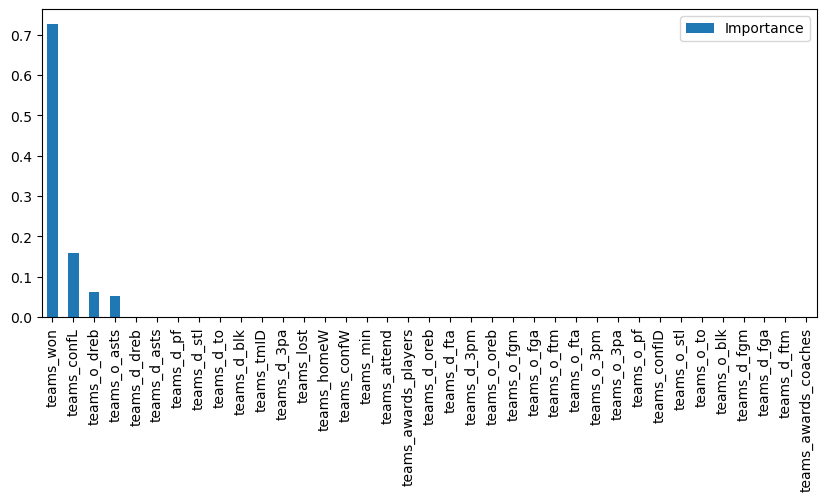

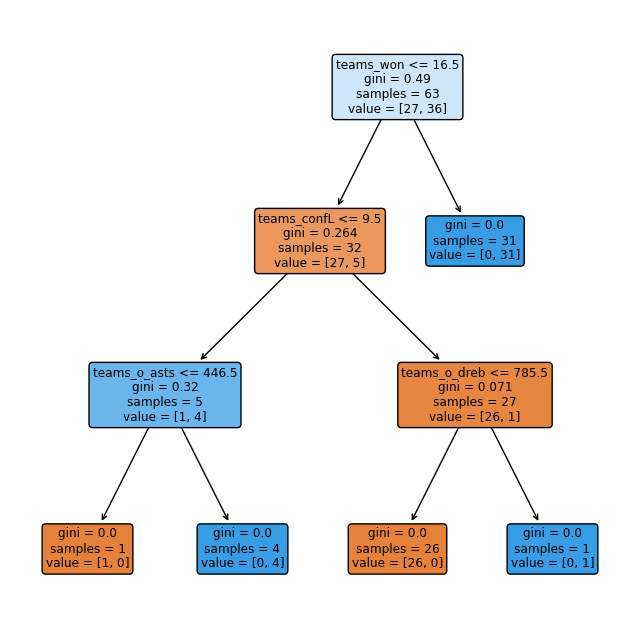


  teams  playoff  prediction
0   LAS        1         1.0
1   MIN        0         0.0
2   PHO        1         1.0
3   SAC        0         0.0
4   SAS        1         1.0
5   SEA        1         1.0
Time: 0.002    Accuracy: 1.00    Precision: 1.00    Recall: 1.00    F1: 1.00    AUC: 1.00


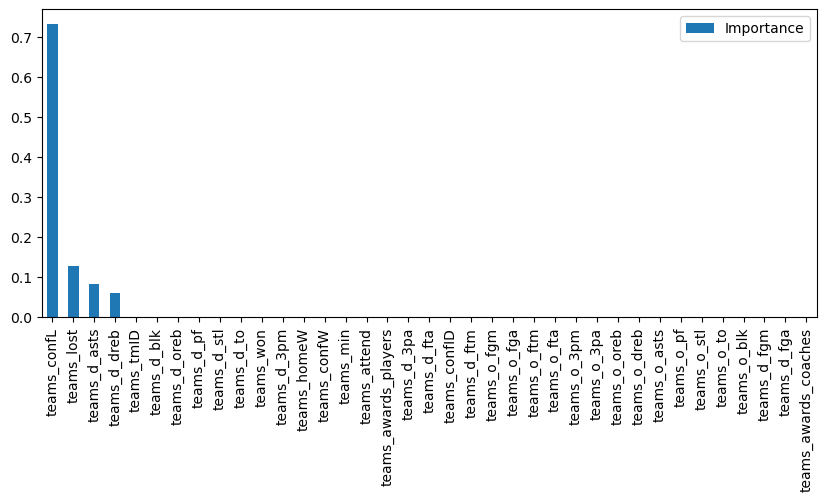

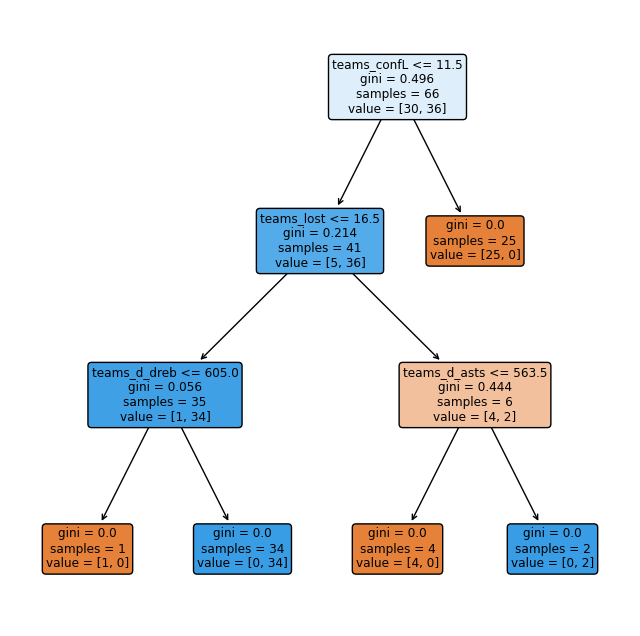


   teams  playoff  prediction
0    ATL        1         0.0
1    CHI        0         0.0
2    CON        0         0.0
3    DET        1         0.0
4    IND        1         1.0
5    LAS        1         1.0
6    MIN        0         1.0
7    NYL        0         1.0
8    PHO        1         1.0
9    SAC        0         0.0
10   SAS        1         1.0
11   SEA        1         1.0
12   WAS        1         1.0
Time: 0.002    Accuracy: 0.69    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.68


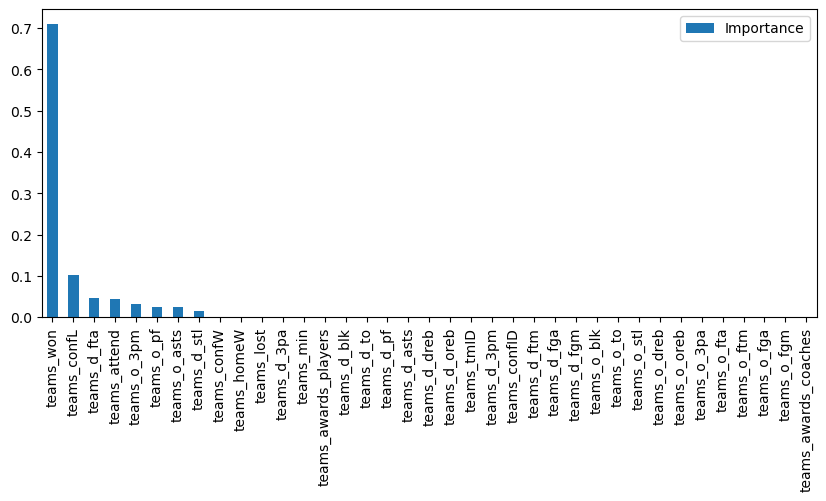

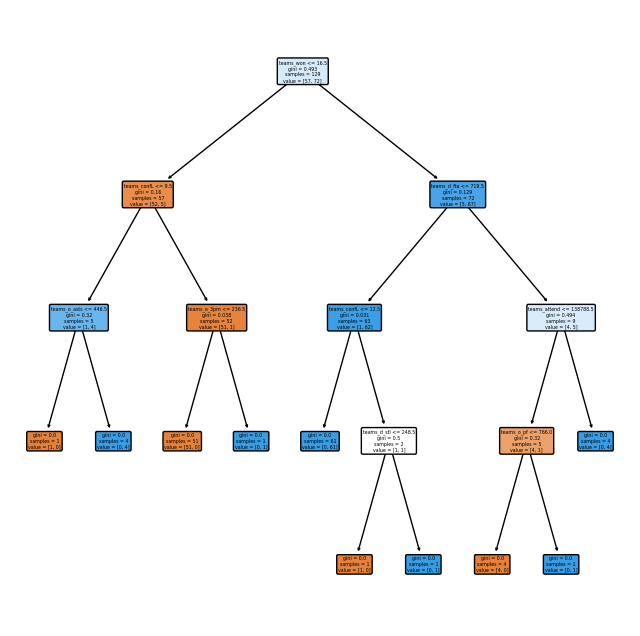

In [11]:
run_model(DecisionTreeClassifier(random_state=42), teams[teams['teams_confID'] == 0], 10, 4)
run_model(DecisionTreeClassifier(random_state=42), teams[teams['teams_confID'] == 1], 10, 4)
run_model(DecisionTreeClassifier(random_state=42), teams, 10, 8)

1.2 - Support Vector Machine

In [12]:
run_model(SVC(probability=True, random_state=42), teams[teams['teams_confID']==0], 10, 4)
run_model(SVC(probability=True, random_state=42), teams[teams['teams_confID']==1], 10, 4)
run_model(SVC(probability=True, random_state=42), teams, 10, 8)


  teams  playoff  prediction
0   ATL        1         1.0
1   CHI        0         1.0
2   CON        0         1.0
3   DET        1         0.0
4   IND        1         1.0
5   NYL        0         0.0
6   WAS        1         0.0
Time: 0.007    Accuracy: 0.43    Precision: 0.50    Recall: 0.50    F1: 0.50    AUC: 0.42

  teams  playoff  prediction
0   LAS        1         0.0
1   MIN        0         1.0
2   PHO        1         0.0
3   SAC        0         1.0
4   SAS        1         1.0
5   SEA        1         1.0
Time: 0.002    Accuracy: 0.33    Precision: 0.50    Recall: 0.50    F1: 0.50    AUC: 0.25

   teams  playoff  prediction
0    ATL        1         0.0
1    CHI        0         0.0
2    CON        0         0.0
3    DET        1         1.0
4    IND        1         1.0
5    LAS        1         1.0
6    MIN        0         0.0
7    NYL        0         1.0
8    PHO        1         1.0
9    SAC        0         1.0
10   SAS        1         0.0
11   SEA        1      

### 1.3 - Grandient Boosting

  teams  playoff  prediction
0   ATL        1         1.0
1   CHI        0         0.0
2   CON        0         0.0
3   DET        1         1.0
4   IND        1         1.0
5   NYL        0         1.0
6   WAS        1         0.0
Time: 0.034    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.71

  teams  playoff  prediction
0   LAS        1         1.0
1   MIN        0         0.0
2   PHO        1         1.0
3   SAC        0         0.0
4   SAS        1         1.0
5   SEA        1         1.0
Time: 0.035    Accuracy: 1.00    Precision: 1.00    Recall: 1.00    F1: 1.00    AUC: 1.00

   teams  playoff  prediction
0    ATL        1         0.0
1    CHI        0         0.0
2    CON        0         0.0
3    DET        1         1.0
4    IND        1         1.0
5    LAS        1         1.0
6    MIN        0         1.0
7    NYL        0         1.0
8    PHO        1         1.0
9    SAC        0         0.0
10   SAS        1         1.0
11   SEA        1      

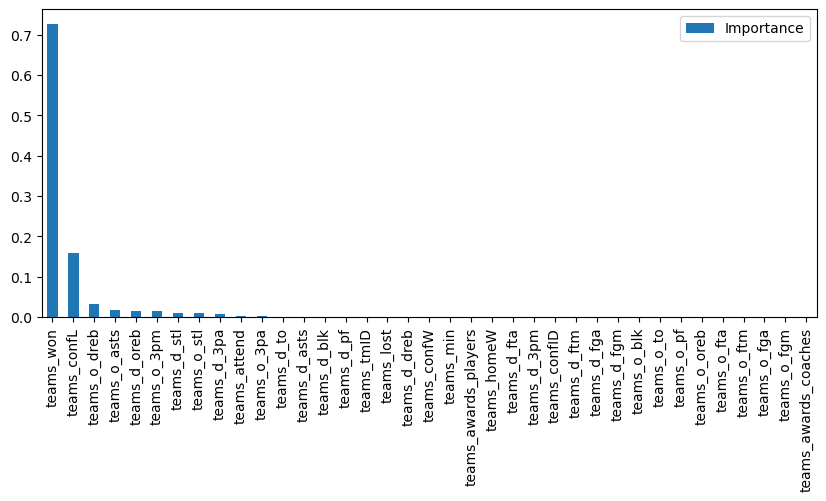

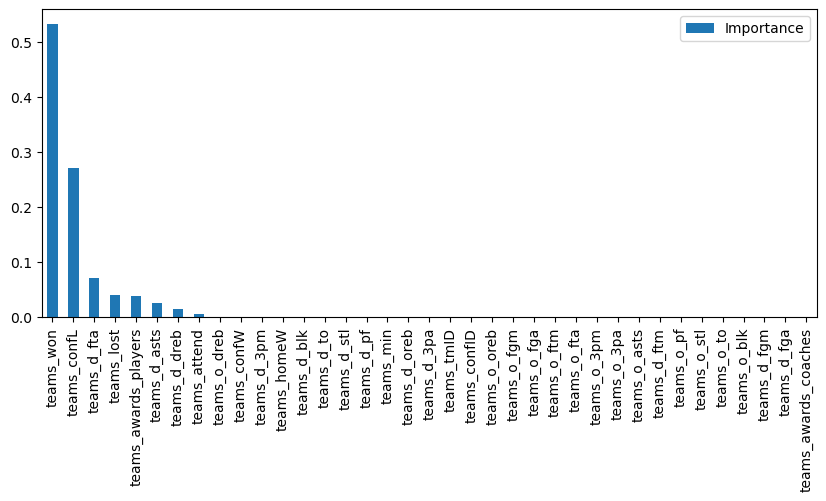

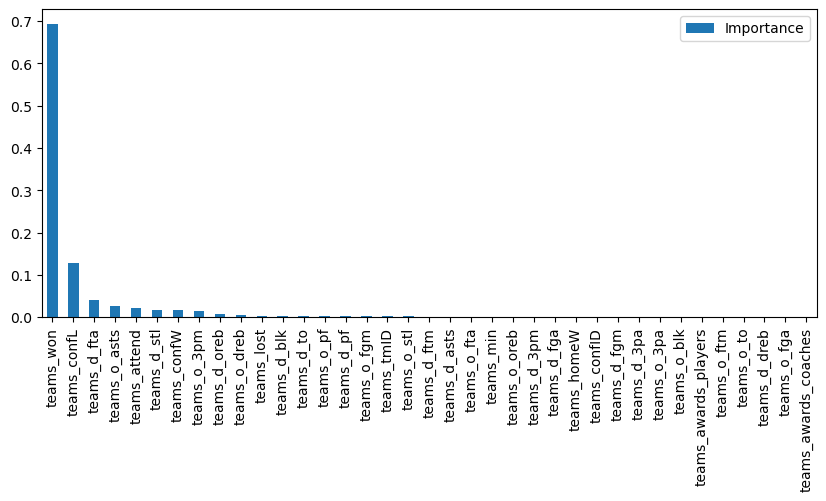

In [13]:
run_model(GradientBoostingClassifier(random_state=42), teams[teams['teams_confID']==0], 10, 4)
run_model(GradientBoostingClassifier(random_state=42), teams[teams['teams_confID']==1], 10, 4)
run_model(GradientBoostingClassifier(random_state=42), teams, 10, 8)


### 1.4 - K Nearest Neighbors

In [14]:
run_model(KNeighborsClassifier(), teams[teams['teams_confID']==0], 10, 4)
run_model(KNeighborsClassifier(), teams[teams['teams_confID']==1], 10, 4)
run_model(KNeighborsClassifier(), teams, 10, 8)

  teams  playoff  prediction
0   ATL        1         1.0
1   CHI        0         0.0
2   CON        0         0.0
3   DET        1         1.0
4   IND        1         1.0
5   NYL        0         1.0
6   WAS        1         0.0
Time: 0.002    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.71

  teams  playoff  prediction
0   LAS        1         1.0
1   MIN        0         0.0
2   PHO        1         0.0
3   SAC        0         1.0
4   SAS        1         1.0
5   SEA        1         1.0
Time: 0.001    Accuracy: 0.67    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.62

   teams  playoff  prediction
0    ATL        1         0.0
1    CHI        0         0.0
2    CON        0         0.0
3    DET        1         1.0
4    IND        1         1.0
5    LAS        1         1.0
6    MIN        0         0.0
7    NYL        0         1.0
8    PHO        1         1.0
9    SAC        0         1.0
10   SAS        1         0.0
11   SEA        1      